In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import mat73
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats, ndimage
from torchvision.utils import make_grid

In [2]:
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"

animal_name = "Caos"
save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", 'feature_mask_estimation', animal_name)
os.makedirs(save_root, exist_ok=True)

server_init = r"N:\PonceLab"

# Define the paths to the data
proto_exp_path = os.path.join(data_root, "evolution", f"unit_proto_{animal_name}")
scram_exp_path = os.path.join(data_root, "scram", f"unit_scram_{animal_name}")
# List .mat files in each directory
proto_exp_files = list_mat_files(proto_exp_path)
scram_exp_files = list_mat_files(scram_exp_path)


In [3]:
# ['all_img_name', 'best_img_selected', 'bk_resp', 'evoke_resp', 'evol_poss', 'evol_size', 'evoled_chan', 'evoled_unit', 'h_evol', 'init_img', 'max_resp', 'mean_img_selected', 'p_evol', 'spikeID', 'spike_fn', 'stimuli_path', 'top_mean_img_selected', 'unitID'])


In [4]:
idx = 21
proto_exp_data = load_mat_data(os.path.join(proto_exp_path, proto_exp_files[idx]))
proto_exp_info = extract_info_proto_exp(proto_exp_files[idx])
exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])

chan_id = int(proto_exp_data['evoled_chan'])
unit_id = int(proto_exp_data['evoled_unit'])

# the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
# let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
# continue if the file is not found
if (len(scram_exp_file) == 0) or (proto_exp_data['p_evol'] > .01):
    print(f"Scrambled file not found for {proto_exp_files[idx]}")
    raise ValueError

scram_exp_file = scram_exp_file[0]
scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
proto_size = scram_exp_info['img_size']
proto_pos = scram_exp_info['img_pos']
protoRespMean = scram_exp_info['protoRespMean']
exp_date = scram_exp_file.split('_')[0].split('-')[1]

proto_img_top_mean = (proto_exp_data['top_mean_img_selected']) # TODO: if you add somthing here you should resize it
proto_img_scram = (scram_exp_info['final_gen_img'])
init_img = (proto_exp_data['init_img'])
proto_mask_exp = scram_exp_info['overlapped_mask_exp']
proto_mask_lin = scram_exp_info['overlapped_mask_lin']
proto_mask_lin_smoothed = ndimage.gaussian_filter(proto_mask_lin, 25)
# if mask is not the size of image_size then resize it
iamge_size = 256
if proto_mask_exp.shape[0] != iamge_size:
    proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
if proto_mask_lin.shape[0] != iamge_size:
    proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
if proto_mask_lin_smoothed.shape[0] != iamge_size:
    proto_mask_lin_smoothed = cv2.resize(proto_mask_lin_smoothed, (iamge_size, iamge_size))
# if the proto_img is not the size of image_size then resize it
if proto_img_top_mean.shape[0] != iamge_size:
    proto_img_top_mean = cv2.resize(proto_img_top_mean, (iamge_size, iamge_size))
if proto_img_scram.shape[0] != iamge_size:
    proto_img_scram = cv2.resize(proto_img_scram, (iamge_size, iamge_size))

proto_img_top_mean = uint8_image_to_pytorch(proto_img_top_mean)
proto_img_scram = uint8_image_to_pytorch(proto_img_scram)
init_img = uint8_image_to_pytorch(init_img)

In [5]:
proto_exp_data['p_evol']

array(3.23162054e-06)

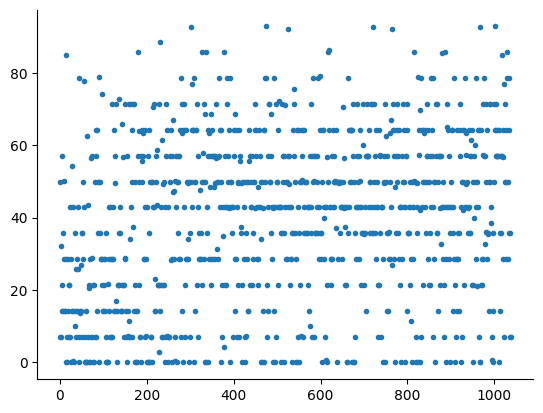

In [6]:
# let's get evolved unit responce
cell_resp = proto_exp_data['evoke_resp'][(proto_exp_data['spikeID'] == proto_exp_data['evoled_chan']) & (proto_exp_data['unitID'] == proto_exp_data['evoled_unit']), :].squeeze()
fig, ax = plt.subplots()
ax.plot(np.arange(cell_resp.shape[0]), cell_resp.squeeze(), '.')

In [7]:
# let get all imaes 
stimuli_path = proto_exp_data['stimuli_path']
images_tensor, image_name_lisst = load_all_images(stimuli_path)

In [9]:
from core.utils.CNN_scorers import TorchScorer
from core.utils.func_lib import *
from core.utils.basic_functions import *

net_name = 'alexnet'
layer_list = ['.features.Conv2d8']
scorer = TorchScorer(net_name)

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
unit_mask_dict, unit_tsridx_dict = set_all_unit_population_recording(scorer, layer_list)
encoded_first_image_batch, _ = encode_image(scorer, images_tensor, key=layer_list,
                                            RFresize=False, cat_layes=False)
encoded_first_image_batch = np.array(encoded_first_image_batch)
scorer.cleanup()

Layer .features.Conv2d8 all units from feature tensor of shape (256, 13, 13)
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [44]:
cell_resp.shape

(0,)

In [29]:
img = 'block001_thread000_gen_gen000_000018'
idx = [i for i, name in enumerate(image_name_lisst) if name in img]
idx

[18, 77]

In [42]:
ii

42

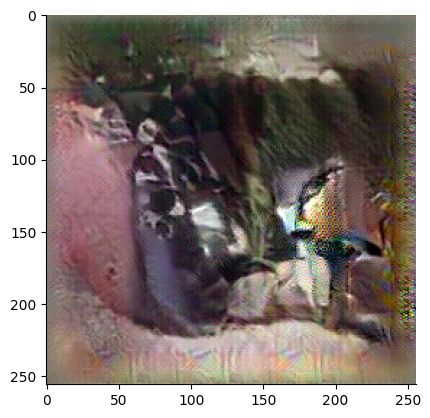

In [25]:
plt.imshow(ToPILImage()(images_tensor[14]))

In [39]:
layer_list_idx = 0
chan_max = unit_tsridx_dict[layer_list[layer_list_idx]][0].max()
H_max = unit_tsridx_dict[layer_list[layer_list_idx]][1].max()
W_max = unit_tsridx_dict[layer_list[layer_list_idx]][2].max()


# let find the coresponing image encoding to each resonce, we should use all_img_name
# to find the index of the image in the images_tensor
cell_resp_coresponing_img_encoded = np.nan * np.ones((cell_resp.shape[0], np.shape(encoded_first_image_batch)[2]))
c_not_found = 0
for ii, img in enumerate(proto_exp_data['all_img_name']):
    # check if wher the img is contained in the image_name_list, img is a string and image_name_list is numpy array of strings
    # let's find the index of the img name is contained in the image_name_list
    idx = [i for i, name in enumerate(image_name_lisst) if name in img]
    if len(idx) == 1:
        id = idx[0]
        cell_resp_coresponing_img_encoded[ii, :] = encoded_first_image_batch[layer_list_idx, id, :]
        # let print the image name forn the two lists
        #print(f"Image name from the proto_exp_data: {img} and from the image_name_list: {image_name_lisst[idx]}")
    elif len(idx) == 0:
        print(f"Image {img} was not found in the image_name_list")
        c_not_found = c_not_found + 1
    elif len(idx) > 1:
        print(f"more that one Image {img} was found in the image_name_list multiple times")
        c_not_found = c_not_found + 1
# let's remove the nan values fron the cell_resp_coresponing_img_encoded and cell_resp
idx = ~np.isnan(cell_resp_coresponing_img_encoded).any(axis=1)
cell_resp_coresponing_img_encoded = cell_resp_coresponing_img_encoded[idx, :]
cell_resp = cell_resp[idx]
print(f"Number of images not found: {c_not_found}")

more that one Image block001_thread000_gen_gen000_000014 was found in the image_name_list multiple times
more that one Image block001_thread000_gen_gen000_000018 was found in the image_name_list multiple times
more that one Image block001_thread000_gen_gen000_000025 was found in the image_name_list multiple times
more that one Image block001_thread000_gen_gen000_000007 was found in the image_name_list multiple times
more that one Image block001_thread000_gen_gen000_000002 was found in the image_name_list multiple times
more that one Image block001_thread000_gen_gen000_000021 was found in the image_name_list multiple times
Image ILSVRC2012_val_00006092_thread000_nat was not found in the image_name_list
more that one Image block001_thread000_gen_gen000_000016 was found in the image_name_list multiple times
more that one Image block001_thread000_gen_gen000_000005 was found in the image_name_list multiple times
Image ILSVRC2012_val_00018202_thread000_nat was not found in the image_name_lis

IndexError: index 42 is out of bounds for axis 0 with size 0

In [10]:
# let find encodingmodel for the cell_resp_coresponing_img_encoded to cell_resp using linear regression
# do the cross validation
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_squared_error

r2_mask_grid_mean = np.zeros([H_max+1, W_max+1])
r2_mask_grid_std = np.zeros([H_max+1, W_max+1])

# let's do the cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#reg = linear_model.LinearRegression()
lasso = linear_model.Lasso()
baseline_model = DummyRegressor(strategy='mean')

for ih in range(H_max+1):
    for iw in range(W_max+1):
        idx_mask = np.where((unit_tsridx_dict[layer_list[layer_list_idx]][1] == ih) & (unit_tsridx_dict[layer_list[layer_list_idx]][2] == iw))[0]
        cell_resp_coresponing_img_encoded_mask = cell_resp_coresponing_img_encoded[:, idx_mask]       
        scores_real = cross_val_score(lasso, cell_resp_coresponing_img_encoded_mask, cell_resp, cv=kf)
        r2_mask_grid_mean[ih, iw] = np.mean(scores_real)
        r2_mask_grid_std[ih, iw] = np.std(scores_real)
        
        
        

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e+02, tolerance: 4.895e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+02, tolerance: 5.126e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

In [1]:
# let plot the r2_mask_grid_mean as a heatmap
fig, ax = plt.subplots(1, 3, figsize=(13, 5))

ax[0].imshow(proto_mask_lin_smoothed)
ax[0].set_title('real mask - scamble exp.')
ax[0].axis('off')

ax[1].imshow(r2_mask_grid_mean)
ax[1].set_title('estimated mask by model')
ax[1].axis('off')

ax[2].imshow(ToPILImage()(proto_img_scram))
ax[2].set_title('prototype image')
ax[2].axis('off')

plt.tight_layout()
# let's save the figure
plt.savefig(os.path.join(save_root, f"mask_estimation_{exp_name_common}_chan{chan_id:02d}_unit{unit_id}.png"))


NameError: name 'plt' is not defined

In [25]:
from core.utils.CNN_scorers import TorchScorer
from core.utils.func_lib import *
from core.utils.basic_functions import *
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_squared_error

net_name = 'alexnet'
layer_list = ['.features.Conv2d8']

# let's do the cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#reg = linear_model.LinearRegression()
lasso = linear_model.Lasso()
baseline_model = DummyRegressor(strategy='mean')

for proto_exp_i in range(130 , len(proto_exp_files)): # TODO: change this to len(proto_exp_files)
    proto_exp_data = load_mat_data(os.path.join(proto_exp_path, proto_exp_files[proto_exp_i]))
    proto_exp_info = extract_info_proto_exp(proto_exp_files[proto_exp_i])
    exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])

    chan_id = int(proto_exp_data['evoled_chan'])
    unit_id = int(proto_exp_data['evoled_unit'])

    # the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
    # let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
    scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
    # continue if the file is not found
    if (len(scram_exp_file) == 0) or (proto_exp_data['p_evol'] > .01):
        print(f"Scrambled file not found for {proto_exp_files[proto_exp_i]}")
        continue

    scram_exp_file = scram_exp_file[0]
    scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
    proto_size = scram_exp_info['img_size']
    proto_pos = scram_exp_info['img_pos']
    protoRespMean = scram_exp_info['protoRespMean']
    exp_date = scram_exp_file.split('_')[0].split('-')[1]

    proto_img_top_mean = (proto_exp_data['top_mean_img_selected']) # TODO: if you add somthing here you should resize it
    proto_img_scram = (scram_exp_info['final_gen_img'])
    init_img = (proto_exp_data['init_img'])
    proto_mask_exp = scram_exp_info['overlapped_mask_exp']
    proto_mask_lin = scram_exp_info['overlapped_mask_lin']
    proto_mask_lin_smoothed = ndimage.gaussian_filter(proto_mask_lin, 25)
    # if mask is not the size of image_size then resize it
    iamge_size = 256
    if proto_mask_exp.shape[0] != iamge_size:
        proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
    if proto_mask_lin.shape[0] != iamge_size:
        proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
    if proto_mask_lin_smoothed.shape[0] != iamge_size:
        proto_mask_lin_smoothed = cv2.resize(proto_mask_lin_smoothed, (iamge_size, iamge_size))
    # if the proto_img is not the size of image_size then resize it
    if proto_img_top_mean.shape[0] != iamge_size:
        proto_img_top_mean = cv2.resize(proto_img_top_mean, (iamge_size, iamge_size))
    if proto_img_scram.shape[0] != iamge_size:
        proto_img_scram = cv2.resize(proto_img_scram, (iamge_size, iamge_size))

    proto_img_top_mean = uint8_image_to_pytorch(proto_img_top_mean)
    proto_img_scram = uint8_image_to_pytorch(proto_img_scram)
    init_img = uint8_image_to_pytorch(init_img)

    cell_resp = proto_exp_data['evoke_resp'][(proto_exp_data['spikeID'] == proto_exp_data['evoled_chan']) & (proto_exp_data['unitID'] == proto_exp_data['evoled_unit']), :].squeeze()

    # let get all imaes 
    stimuli_path = proto_exp_data['stimuli_path']
    images_tensor, image_name_lisst = load_all_images(stimuli_path)


    scorer = TorchScorer(net_name)
    unit_mask_dict, unit_tsridx_dict = set_all_unit_population_recording(scorer, layer_list)
    encoded_first_image_batch, _ = encode_image(scorer, images_tensor, key=layer_list,
                                                RFresize=False, cat_layes=False)
    encoded_first_image_batch = np.array(encoded_first_image_batch)
    scorer.cleanup()

    layer_list_idx = 0
    chan_max = unit_tsridx_dict[layer_list[layer_list_idx]][0].max()
    H_max = unit_tsridx_dict[layer_list[layer_list_idx]][1].max()
    W_max = unit_tsridx_dict[layer_list[layer_list_idx]][2].max()


    # let find the coresponing image encoding to each resonce, we should use all_img_name
    # to find the index of the image in the images_tensor
    mised_img = 0
    cell_resp_coresponing_img_encoded = np.nan * np.ones((cell_resp.shape[0], np.shape(encoded_first_image_batch)[2]))
    for ii, img in enumerate(proto_exp_data['all_img_name']):
        # check if wher the img is contained in the image_name_list, img is a string and image_name_list is numpy array of strings
        # let's find the index of the img name is contained in the image_name_list
        idx = [i for i, name in enumerate(image_name_lisst) if name in img]
        if len(idx) == 1:
            idx = idx[0]
            cell_resp_coresponing_img_encoded[ii, :] = encoded_first_image_batch[layer_list_idx, idx, :]
            # let print the image name forn the two lists
            #print(f"Image name from the proto_exp_data: {img} and from the image_name_list: {image_name_lisst[idx]}")
        else:
            mised_img += 1
    # let's remove the nan values fron the cell_resp_coresponing_img_encoded and cell_resp
    idx = ~np.isnan(cell_resp_coresponing_img_encoded).any(axis=1)
    cell_resp_coresponing_img_encoded = cell_resp_coresponing_img_encoded[idx, :]
    cell_resp = cell_resp[idx]
    print(f"Missed images: {cell_resp_coresponing_img_encoded.shape[0] - np.sum(idx)}")

    layer_list_idx = 0
    chan_max = unit_tsridx_dict[layer_list[layer_list_idx]][0].max()
    H_max = unit_tsridx_dict[layer_list[layer_list_idx]][1].max()
    W_max = unit_tsridx_dict[layer_list[layer_list_idx]][2].max()

    r2_mask_grid_mean = np.zeros([H_max+1, W_max+1])
    r2_mask_grid_std = np.zeros([H_max+1, W_max+1])

    for ih in range(H_max+1):
        for iw in range(W_max+1):
            idx_mask = np.where((unit_tsridx_dict[layer_list[layer_list_idx]][1] == ih) & (unit_tsridx_dict[layer_list[layer_list_idx]][2] == iw))[0]
            cell_resp_coresponing_img_encoded_mask = cell_resp_coresponing_img_encoded[:, idx_mask]       
            scores_real = cross_val_score(lasso, cell_resp_coresponing_img_encoded_mask, cell_resp, cv=kf)
            r2_mask_grid_mean[ih, iw] = np.mean(scores_real)
            r2_mask_grid_std[ih, iw] = np.std(scores_real)

    # let plot the r2_mask_grid_mean as a heatmap
    fig, ax = plt.subplots(1, 3, figsize=(13, 5))

    ax[0].imshow(proto_mask_lin_smoothed)
    ax[0].set_title('real mask - scamble exp.')
    ax[0].axis('off')

    ax[1].imshow(r2_mask_grid_mean)
    ax[1].set_title('estimated mask by model')
    ax[1].axis('off')

    ax[2].imshow(ToPILImage()(proto_img_scram))
    ax[2].set_title('prototype image')
    ax[2].axis('off')

    plt.tight_layout()
    # let's save the figure
    plt.savefig(os.path.join(save_root, f"mask_estimation_{exp_name_common}_chan{chan_id:02d}_unit{unit_id}_missed{mised_img}.png"))
    plt.close()

Layer .features.Conv2d8 all units from feature tensor of shape (256, 13, 13)
Cleanuping...
Cleanup hooks done.
Cleanup done.
Missed images: 0


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e+02, tolerance: 9.570e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+03, tolerance: 9.415e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Layer .features.Conv2d8 all units from feature tensor of shape (256, 13, 13)
Cleanuping...
Cleanup hooks done.
Cleanup done.
Missed images: 0


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

In [21]:
proto_exp_i


123